In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from MyModels import DenseModel
import ipywidgets as widgets
from ipywidgets import interact, Layout
from Training import training
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device}")

DenseModel: hidden_layers:1, neurons_per_layer:1, activation_hidden:relu, activation_output:linear
Running on: cuda


In [2]:
def generate_data(obs_type='linear', error_size=2, n = 100):
    '''Generates data for linear, quadratic or harmonic function'''
    torch.manual_seed(4)
    x = torch.linspace(0, 2 * np.pi, n)
    if obs_type == 'linear':
        m = 1*torch.rand(1) -1
        b = 1*torch.rand(1) -1
        y = x*m + b + torch.rand(x.shape)*error_size
    elif obs_type == 'quadratic':
        a = 2*torch.rand(1) -1
        b = 2*torch.rand(1) -1
        c = 2*torch.rand(1) -1
        y =  a*x**2 + b*x + c + torch.rand(x.shape)*error_size
    elif obs_type == 'harmonic':
        a = 2 * torch.rand(1) - 1
        b = 8 * torch.rand(1) - 1
        c = 5 * torch.rand(1) - 1
        d = 2 * torch.rand(1) - 1
        y = a*x**2 + b*np.sin(x) + c*np.cos(3*x) + d + torch.rand(x.shape)*error_size

    idxs = torch.randperm(x.shape[0])
    return x[idxs], y[idxs]


In [3]:
def split_data(x,y, train_percentage=0.8, validation_percentage=0.1):
    '''Splits data into train, validation and test'''
    train_size = int(x.shape[0]*train_percentage)
    validation_size = int(x.shape[0]*validation_percentage)
    x_train = x[:train_size]
    y_train = y[:train_size]
    x_validation = x[train_size:train_size + validation_size]
    y_validation = y[train_size:train_size + validation_size]
    x_test = x[train_size + validation_size:]
    y_test = y[train_size + validation_size:]
    return x_train, y_train, x_validation, y_validation, x_test, y_test

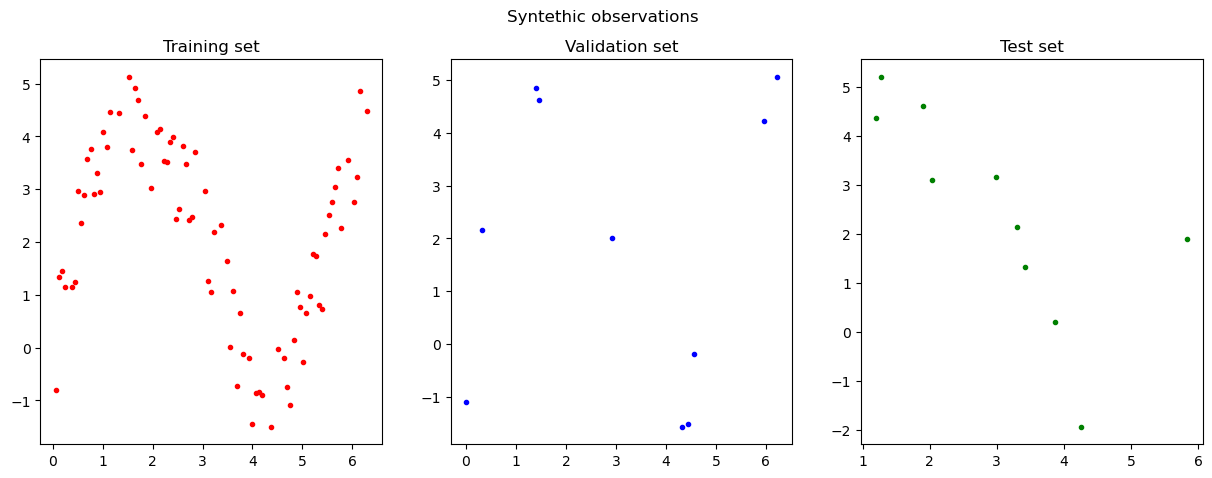

In [4]:
x, y = generate_data(obs_type='harmonic', n=100)
x_train, y_train, x_validation, y_validation, x_test, y_test = split_data(x, y, train_percentage=0.8, validation_percentage=0.1)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle("Syntethic observations")
axs[0].plot(x_train, y_train, 'r.')
axs[0].set_title('Training set')
axs[1].plot(x_validation, y_validation, 'b.')
axs[1].set_title('Validation set')
axs[2].plot(x_test, y_test, 'g.')
axs[2].set_title('Test set')
plt.show()

In [5]:
def plot_data(x, y, x_val, y_val, model, loss_history, loss_history_val, title=""):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    X = torch.reshape(x, (x.shape[0], 1)).to(device)
    model_y = model(X).cpu().detach().numpy()
    axs[0].plot(x, y, '.')
    axs[0].plot(x_val, y_val, 'y.')
    axs[0].plot(x, model_y, color='r')
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")
    axs[1].semilogy(range(len(loss_history)), loss_history, color='r', label='Training')
    axs[1].semilogy(range(len(loss_history_val)), loss_history_val, color='g', label='Validation')
    axs[1].set_yscale('log')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("MSE")
    axs[1].legend()
    plt.suptitle(title, fontsize=17)
    plt.tight_layout()
    plt.show()

In [6]:
@interact(hidden_layers=widgets.IntSlider(min=1, max=10, step=1, value=5,  description='Hidden layers'),
            neurons_per_layer=widgets.IntSlider(min=1, max=100, step=1, value=20, layout=Layout(width='500px'), description='Neurons HLayers'),
            activation_hidden=widgets.Dropdown(options=['relu', 'sigmoid', 'tanh', 'linear'], value='relu', layout=Layout(width='500px'), description='Act. Hidden'),
            epochs=widgets.IntSlider(min=100, max=2000, step=100, value=500, layout=Layout(width='500px'), description='Epochs'),
            activation_output=widgets.Dropdown(options=['relu', 'sigmoid', 'tanh', 'linear'], value='linear', description='Act. Output'),
            batch_norm_str=widgets.Dropdown(options=['With', 'Without'], value='With', description='Batch Norm'))
def NN_TestBed(hidden_layers=1, neurons_per_layer=1, epochs=500, activation_hidden='relu', activation_output='linear', batch_norm_str='With'):
    
    button = widgets.Button(description="Start Training!")
    output = widgets.Output()

    def on_button_click(b):
        with output:
            clear_output(wait=True)
            print("Training...")
            batch_norm = True if batch_norm_str == 'With' else False
            model = DenseModel(hidden_layers, neurons_per_layer, activation_hidden, activation_output, batch_norm).to(device)
            print("Total number of parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
            # for name, param in model.state_dict().items():
            #     print(name)

            t = time.time()
            loss_history, loss_history_val, trained_model = training(loss=nn.MSELoss(),
                                                                     optimizer=torch.optim.Adam(model.parameters(), lr=0.01), model=model, epochs=epochs, x=x_train, y=y_train, x_val=x_validation, y_val=y_validation, device=device)

            title = f"Best Training loss:{np.min(loss_history[-1]):0.2f} Best Validation loss:{np.min(loss_history_val[-1]):0.2f} \n Hidden layers: {hidden_layers}, Neurons per layer: {neurons_per_layer}, Activation (hidden): {activation_hidden}, Batch norm: {batch_norm}"

            print(f"Done! Time:{(time.time() - t):0.2f} seg")
            print(f"Last loss: {loss_history[-1]:0.2f}")
            _, idxs = x_train.sort()
            _, idxs_val = x_validation.sort()
            plot_data(x_train[idxs], y_train[idxs], x_validation[idxs_val], y_validation[idxs_val], trained_model, loss_history, loss_history_val, title = title)
            del model
            
    button.on_click(on_button_click)
    display(button)
    display(output)

interactive(children=(IntSlider(value=5, description='Hidden layers', max=10, min=1), IntSlider(value=20, desc…